# XAUUSD Bi-GRU + ARIMA Hybrid Model

**Based on Paper:** Implementation of GRU, LSTM and Derivatives for Gold Price Prediction

**Best Configuration from Paper:**
- Model: Bi-GRU (Bidirectional GRU)
- Optimizer: Nadam
- Batch Size: 8
- Time Steps: 20
- Learning Rate: 0.0001
- Target MAPE: 0.8857%

In [17]:
# Setup
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f'[INFO] GPU Enabled: {len(gpus)} device(s)')
else:
    print('[INFO] Running on CPU')

# Add source path
sys.path.append(os.path.abspath(''))

from src.data_loader import DataLoader
from src.hybrid_bigru_model import HybridBiGRUModel
from src.utils import calculate_metrics

[INFO] GPU Enabled: 1 device(s)


## 1. Configuration (Paper Parameters)

In [18]:
# --- CONFIGURATION (Paper Optimized) --- #
SYMBOL = 'XAUUSD'
TIMEFRAME = '1h'
PERIOD = '2y'

# Backtest Mode (True = Train on history, Test on last 7 days)
BACKTEST_MODE = True
BACKTEST_DAYS = 7

# Paper-recommended parameters
LOOK_BACK = 20          # Time steps (paper: 20)
BATCH_SIZE = 8          # Batch size (paper: 8)
EPOCHS = 100            # Epochs (paper: 1000 with early stopping)
LEARNING_RATE = 0.0001  # Learning rate (paper: 0.0001)

# Forecast settings
FUTURE_HOURS = 8        # Hours to forecast
# ---------------------------------------- #

## 2. Load Data

In [19]:
print(f'Loading {SYMBOL} data ({TIMEFRAME})...')
loader = DataLoader(symbol=SYMBOL, interval=TIMEFRAME, period=PERIOD, 
                    data_path=f'data/gold_{TIMEFRAME}.csv')

csv_path = f'data/gold_{TIMEFRAME}.csv'
if os.path.exists(csv_path):
    print(f'Loading from cached file: {csv_path}')
    df = loader.fetch_data(source='auto')
else:
    df = loader.fetch_data(source='auto', force_download=True)

if df is not None and not df.empty:
    print(f'Loaded {len(df)} rows')
    display(df.tail())
else:
    print('ERROR: No data available.')

Loading XAUUSD data (1h)...
Loading from cached file: data/gold_1h.csv
Loading data from data/gold_1h.csv
Loaded 13763 rows


,Open,High,Low,Close,Volume
Datetime,,,,,
2025-12-05 17:00:00+00:00,4244.000000,4251.000000,4236.000000,4248.399902,10239
2025-12-05 18:00:00+00:00,4248.200195,4250.299805,4236.899902,4239.299805,9449
2025-12-05 19:00:00+00:00,4239.299805,4241.100098,4205.100098,4237.299805,4787
2025-12-05 20:00:00+00:00,4237.600098,4237.600098,4229.000000,4231.600098,5054
2025-12-05 21:00:00+00:00,4231.399902,4231.700195,4194.500000,4227.700195,3823


## 3. Preprocess Data

In [20]:
# Prepare data with paper-recommended look_back
X, y, scaled_data = loader.prepare_data_for_lstm(df, look_back=LOOK_BACK)

if BACKTEST_MODE:
    # Calculate cutoff for last N days
    last_idx = df.index[-1]
    split_date = last_idx - pd.Timedelta(days=BACKTEST_DAYS)
    
    print(f"⚠️ BACKTEST MODE ON")
    print(f"  Training End / Test Start: {split_date}")
    
    # Count how many candles are in the test period
    test_rows = df[df.index > split_date]
    n_test = len(test_rows)
    
    # Limit n_test to prevent index errors
    n_test = min(n_test, int(len(y) * 0.5))
    
    train_size = len(y) - n_test
    print(f"  Test Samples (Last {BACKTEST_DAYS} days): {n_test}")
else:
    # Standard 80/20 Split
    train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Train samples: {X_train.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')
print(f'Input shape: {X_train.shape}')


⚠️ BACKTEST MODE ON
  Training End / Test Start: 2025-11-28 21:00:00+00:00
  Test Samples (Last 7 days): 115
Train samples: 13628
Test samples: 115
Input shape: (13628, 20, 1)


## 4. Train Bi-GRU + ARIMA Hybrid Model

In [ ]:
# Create model with paper parameters
input_shape = (X.shape[1], X.shape[2])
model = HybridBiGRUModel(
    input_shape=input_shape,
    units=64,
    dropout_rate=0.2,
    learning_rate=LEARNING_RATE
)

print('Training Bi-GRU + ARIMA Hybrid Model...')
print(f'Parameters: epochs={EPOCHS}, batch_size={BATCH_SIZE}, lr={LEARNING_RATE}')
model.train(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

/home/vanszs/Code/XAUUSD_Pred_Bot/venv/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Bi-GRU + ARIMA Hybrid Model...
Parameters: epochs=100, batch_size=8, lr=0.0001
Training Bi-GRU model...
Epoch 1/100


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 122s 67ms/step - loss: 0.0037 - mae: 0.0277 - val_loss: 1.3329e-04 - val_mae: 0.0090
Epoch 2/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 112s 73ms/step - loss: 4.4940e-04 - mae: 0.0141 - val_loss: 6.0239e-04 - val_mae: 0.0228
Epoch 3/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 106s 69ms/step - loss: 3.2913e-04 - mae: 0.0122 - val_loss: 1.3547e-04 - val_mae: 0.0088
Epoch 4/100
 928/1534 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - loss: 2.7195e-04 - mae: 0.0113

## 5. Evaluate Model (Paper Metrics)


     BI-GRU + ARIMA HYBRID MODEL EVALUATION
  MAE:       0.0109
  MSE:       0.0002
  RMSE:      0.0142
  MAPE:      1.3356%  (Paper target: 0.8857%)
  R²:        0.988273
  Accuracy:  98.66%


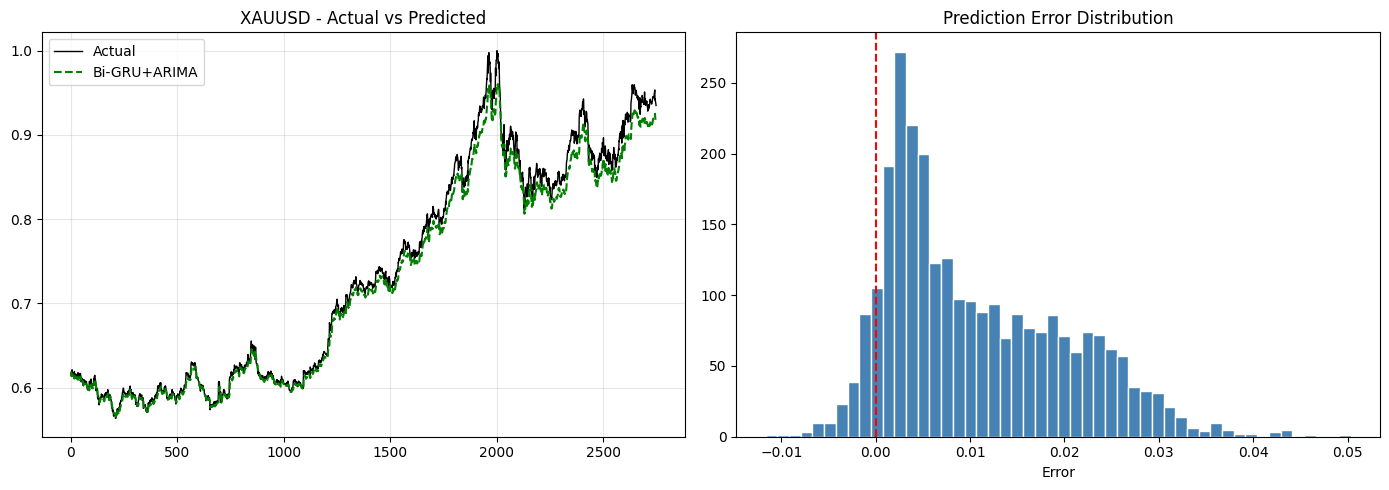

In [ ]:
# Predict on test set
final_preds, bigru_preds, arima_preds = model.predict(X_test)

# Calculate metrics
metrics = calculate_metrics(y_test, final_preds)

# Display metrics with paper comparison
print('\n' + '='*50)
print('     BI-GRU + ARIMA HYBRID MODEL EVALUATION')
print('='*50)
print(f"  MAE:       {metrics['MAE']:.4f}")
print(f"  MSE:       {metrics['MSE']:.4f}")
print(f"  RMSE:      {metrics['RMSE']:.4f}")
print(f"  MAPE:      {metrics['MAPE']:.4f}%  (Paper target: 0.8857%)")
print(f"  R²:        {metrics['R2']:.6f}")
print(f"  Accuracy:  {metrics['Accuracy']:.2f}%")
print('='*50)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Actual vs Predicted
axes[0].plot(y_test, label='Actual', color='black', linewidth=1)
axes[0].plot(final_preds, label='Bi-GRU+ARIMA', color='green', linestyle='--')
axes[0].set_title(f'{SYMBOL} - Actual vs Predicted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Error distribution
errors = y_test.flatten() - final_preds.flatten()
axes[1].hist(errors, bins=50, color='steelblue', edgecolor='white')
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_title('Prediction Error Distribution')
axes[1].set_xlabel('Error')

plt.tight_layout()
plt.show()

## 6. Future Forecast

Forecasting 8 hours (8 candles)...
Generating 8-step future prediction...


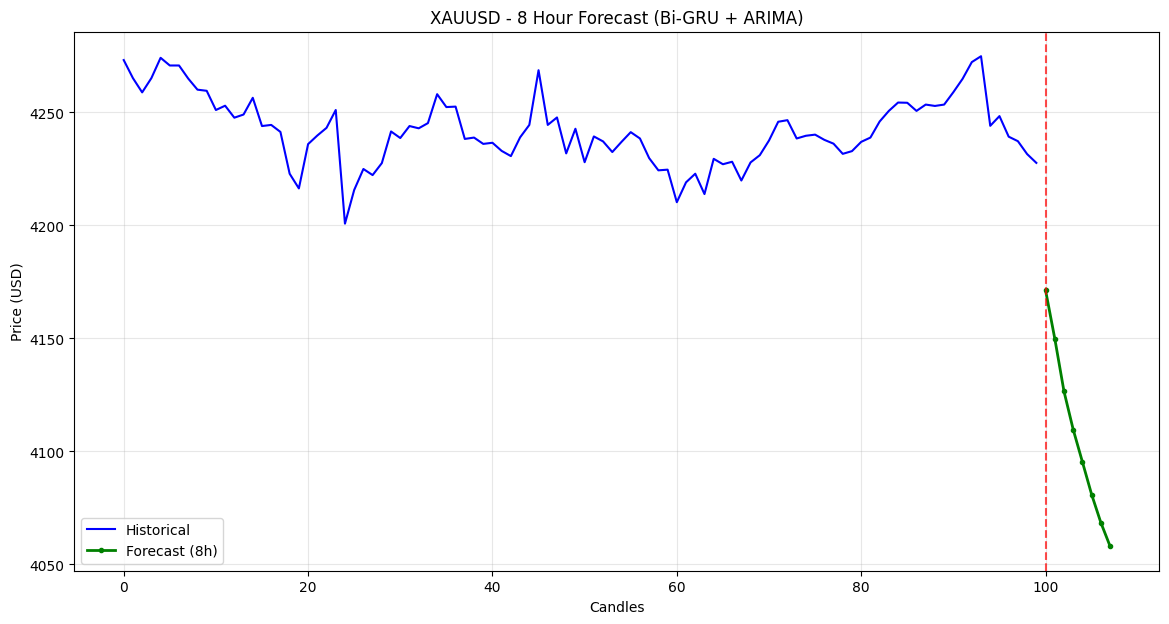


=== FORECAST SUMMARY ===
  Current Price:  $4227.70
  Forecast Price: $4058.06
  Direction:      📉 BEARISH
  Change:         $-169.64 (-4.01%)


In [ ]:
# Calculate forecast steps
if TIMEFRAME == '15m':
    steps = FUTURE_HOURS * 4
elif TIMEFRAME == '30m':
    steps = FUTURE_HOURS * 2
else:
    steps = FUTURE_HOURS

print(f'Forecasting {FUTURE_HOURS} hours ({steps} candles)...')

# Get last sequence
last_sequence = scaled_data[-LOOK_BACK:].reshape(1, LOOK_BACK, 1)

# Predict future
future_preds, bigru_future, arima_future = model.predict_future(last_sequence, steps)

# Inverse scale
future_prices = loader.inverse_transform(future_preds)

# History for context
history_length = 100
history_prices = loader.inverse_transform(scaled_data[-history_length:].reshape(-1, 1))

# Plot
plt.figure(figsize=(14, 7))
x_history = np.arange(history_length)
x_forecast = np.arange(history_length, history_length + steps)

plt.plot(x_history, history_prices, label='Historical', color='blue', linewidth=1.5)
plt.plot(x_forecast, future_prices, label=f'Forecast ({FUTURE_HOURS}h)', 
         color='green', linewidth=2, marker='.')
plt.axvline(x=history_length, color='red', linestyle='--', alpha=0.7)

plt.title(f'{SYMBOL} - {FUTURE_HOURS} Hour Forecast (Bi-GRU + ARIMA)')
plt.xlabel('Candles')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Summary
change = future_prices[-1,0] - history_prices[-1,0]
pct = (change / history_prices[-1,0]) * 100
direction = '📈 BULLISH' if change > 0 else '📉 BEARISH'

print(f'\n=== FORECAST SUMMARY ===')
print(f'  Current Price:  ${history_prices[-1,0]:.2f}')
print(f'  Forecast Price: ${future_prices[-1,0]:.2f}')
print(f'  Direction:      {direction}')
print(f'  Change:         ${change:.2f} ({pct:.2f}%)')

## 7. Real-World Metrics (Inverse Scaled)
Convert metrics from normalized (0-1) scale to actual USD prices for better intuition.

In [ ]:
# Inverse transform test target and predictions
y_test_inv = loader.inverse_transform(y_test)
final_preds_inv = loader.inverse_transform(final_preds)

# Calculate real metrics
real_metrics = calculate_metrics(y_test_inv, final_preds_inv)

print('\n' + '='*50)
print('     REAL-WORLD (USD) METRICS')
print('='*50)
print(f"  MAE:       ${real_metrics['MAE']:.2f}")
print(f"  RMSE:      ${real_metrics['RMSE']:.2f}")
print(f"  Max Error: ${real_metrics['Max_Error']:.2f}")
print(f"  MAPE:      {real_metrics['MAPE']:.4f}% (Price Error)")
print(f"  Directional Accuracy: {real_metrics['DA']:.2f}%")
print('='*50)


     REAL-WORLD (USD) METRICS
  MAE:       $27.91
  RMSE:      $36.48
  Max Error: $129.15
  MAPE:      0.7082% (Price Error)
  Directional Accuracy: 49.56%


## 8. Save Model
Save the Keras model and ARIMA parameters.

In [ ]:
import pickle

# Save Bi-GRU Keras model
model.bigru.model.save('models/bigru_final.keras')
print("✅ Bi-GRU model saved to models/bigru_final.keras")

# Save ARIMA model (pickling the FitResults)
with open('models/arima_model.pkl', 'wb') as f:
    pickle.dump(model.arima.model_fit, f)
print("✅ ARIMA model saved to models/arima_model.pkl")

print("\nAll models saved successfully!")

✅ Bi-GRU model saved to models/bigru_final.keras
✅ ARIMA model saved to models/arima_model.pkl

All models saved successfully!
